**Model Zoo -- Convolutional Variational Autoencoder**

A simple convolutional variational autoencoder that compresses 768-pixel MNIST images down to a 15-pixel latent vector representation.



In [17]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms



**Data**

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_features = 784
num_latent = 15


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [19]:
import torch.nn as nn

**AutoEncoder**

In [22]:

class ConvVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_latent):
        super(ConvVariationalAutoencoder, self).__init__()
        
        ###############
        # ENCODER
        ##############
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        
        
        ###############
        # DECODER
        ##############
        
        self.dec_linear_1 = torch.nn.Linear(num_latent, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=1,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)


    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features):
        x = self.enc_conv_1(features)
        x = F.leaky_relu(x)
        #print('conv1 out:', x.size())
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        #print('conv2 out:', x.size())
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        #print('conv3 out:', x.size())
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded):
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        #print('deconv2 out:', x.size())
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features):
        
        z_mean, z_log_var, encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConvVariationalAutoencoder(num_features,
                                   num_latent)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


**Training**

In [23]:
start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/469 | Cost: 70508.8203
Epoch: 001/050 | Batch 050/469 | Cost: 69360.6875
Epoch: 001/050 | Batch 100/469 | Cost: 41197.5898
Epoch: 001/050 | Batch 150/469 | Cost: 34549.7500
Epoch: 001/050 | Batch 200/469 | Cost: 28113.2520
Epoch: 001/050 | Batch 250/469 | Cost: 29081.8965
Epoch: 001/050 | Batch 300/469 | Cost: 27349.2207
Epoch: 001/050 | Batch 350/469 | Cost: 26395.8008
Epoch: 001/050 | Batch 400/469 | Cost: 25633.8145
Epoch: 001/050 | Batch 450/469 | Cost: 25571.6641
Time elapsed: 0.10 min
Epoch: 002/050 | Batch 000/469 | Cost: 25358.7285
Epoch: 002/050 | Batch 050/469 | Cost: 24168.3379
Epoch: 002/050 | Batch 100/469 | Cost: 24112.3379
Epoch: 002/050 | Batch 150/469 | Cost: 24323.6211
Epoch: 002/050 | Batch 200/469 | Cost: 24361.7305
Epoch: 002/050 | Batch 250/469 | Cost: 23242.0820
Epoch: 002/050 | Batch 300/469 | Cost: 23678.1113
Epoch: 002/050 | Batch 350/469 | Cost: 23405.6211
Epoch: 002/050 | Batch 400/469 | Cost: 22849.8262
Epoch: 002/050 | Batch 450/

**Original Images**

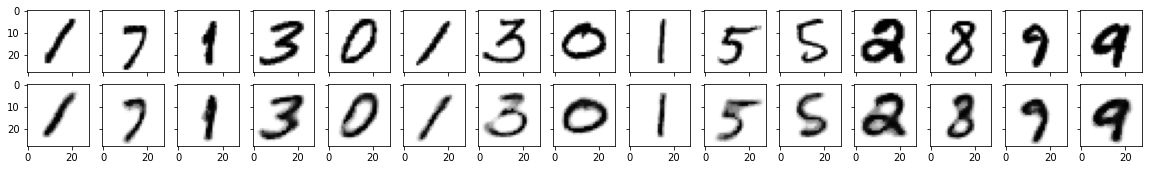

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt


n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')
                     

**Random Sampling**

**Compressed image**

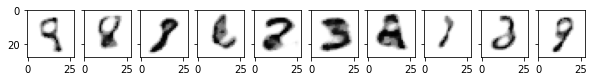

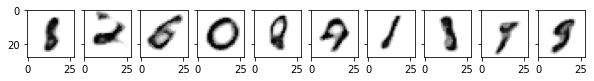

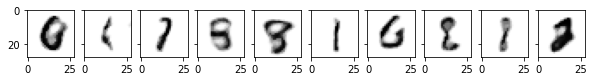

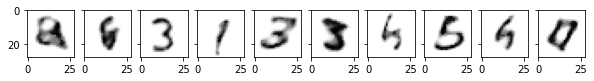

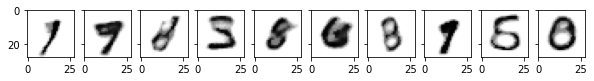

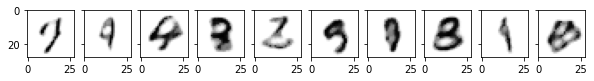

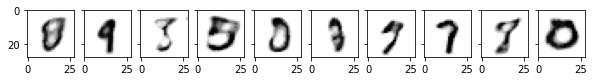

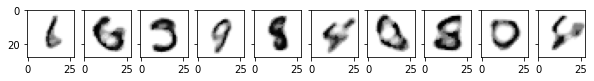

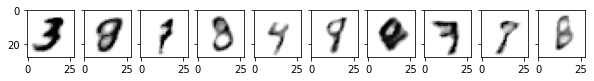

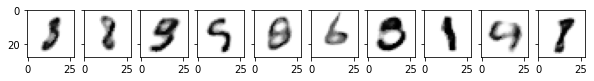

In [27]:
for i in range(10):
  
    
    n_images = 10
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]

    for ax, img in zip(axes, decoded_images):
        ax.imshow(img.detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')
        
    plt.show()